# 5) Collocation Network

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Visualize word collocations as a network graph where nodes are words and edges are bigram co-occurrences.
- Identify hub words (high degree) that co-occur frequently with many other words.
- Filter edges by frequency threshold to focus on strong collocations and reveal phrase structure.

Learning objectives:
- Represent bigram data as a network graph using NetworkX.
- Compute and visualize largest connected components to see collocation clusters.
- Interpret node degree as a measure of word centrality in phrasal patterns.
- Use network visualization to explore stylistic and thematic phrase structure.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. Adjust `min_ngram_count` to control edge density (higher = sparser graph, clearer hubs).
3. (Optional) Toggle `use_stopwords` to remove function words and focus on content-word collocations.
4. Run cells from top to bottom. The main outputs are saved to `../results/`.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, networkx).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- Network graph: each word is a node; each bigram (a, b) creates an edge between nodes a and b weighted by co-occurrence count.
- Self-loops (edges from a word to itself) are filtered out for clarity.
- Largest connected component is extracted to avoid isolated word pairs cluttering the visualization.
- Node size scales with degree (number of connections); hub words appear larger.
- Edge width scales with weight (bigram count); frequent collocations appear thicker.
- Spring layout: positions nodes to minimize edge crossings and reveal structure.
- Consider removing stopwords first or filtering to content-words (nouns, verbs, adjectives) for cleaner networks.
- Compare per-book networks by running the same code on `text1` and `text2` separately to see shifts in collocation patterns.

**Goal:** Build and visualize a collocation network to explore phrase structure and identify hub words in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [25]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/PetSemetary.txt",   # Pet Sematary
    "book2_path": "../data/TheShining.txt",    # The Shining
    "language": "en",
    "use_stopwords": False,                    # you can toggle this
    "min_ngram_count": 5,
    "top_k": 20
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()

## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [26]:
def load_text(p: str) -> str:
    """Load text file as UTF-8, ignoring bad bytes."""
    return Path(p).read_text(encoding="utf-8", errors="ignore")

def normalize_text(t: str) -> str:
    """Simple normalization for local TXT files (not Gutenberg)."""
    if not t:
        return ""
    # normalize curly apostrophes to ASCII '
    t = t.replace("’", "'").replace("‘", "'")
    # join hyphenated line breaks (e.g., "won-\n derful" → "wonderful")
    t = re.sub(r"-\s*\n", "", t)
    # normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Load + normalize
text1 = normalize_text(load_text(CONFIG["book1_path"]))  # Pet Sematary
text2 = normalize_text(load_text(CONFIG["book2_path"]))  # The Shining

# Tokenize
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

# Optional: prune junk 1–2 letter tokens to keep network clean
keep_1 = {"a", "i"}
keep_2 = {
    "of","to","in","on","by","an","or","as","is","it","we","us","he","me","my",
    "so","be","do","no","at","up","if","go","am","oh"
}

tokens1 = [
    t for t in tokens1
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]
tokens2 = [
    t for t in tokens2
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]

# Combined corpus for a single network (you can also build two separate ones if you want)
tokens = tokens1 + tokens2

print("Token counts after normalization + pruning:")
print("Pet Sematary:", len(tokens1))
print("The Shining :", len(tokens2))
print("Combined    :", len(tokens))


Token counts after normalization + pruning:
Pet Sematary: 145778
The Shining : 160457
Combined    : 306235


## 2. Build Bigram Graph

- Nodes: words
- Edges: bigrams (weight = co-occurrence count)
- Filter edges by `min_ngram_count` for clarity


In [27]:
from collections import Counter
import networkx as nx

# --- Choose which tokens you want the network for ---
# Option A: combined network for both books
network_tokens = tokens

# Option B: per-book networks (uncomment one if you want that instead)
# network_tokens = tokens1   # Pet Sematary only
# network_tokens = tokens2   # The Shining only

# --- Optional: extra pruning before building the graph ---
keep_1 = {"a", "i"}
keep_2 = {
    "of","to","in","on","by","an","or","as","is","it","we","us","he","me","my",
    "so","be","do","no","at","up","if","go","am","oh"
}

clean_tokens = [
    t for t in network_tokens
    if (len(t) > 2)
       or (len(t) == 1 and t in keep_1)
       or (len(t) == 2 and t in keep_2)
]

# --- Build bigram counts ---
bigrams_counts = Counter(zip(clean_tokens, clean_tokens[1:]))
min_c = CONFIG["min_ngram_count"]

# edges = (word_a, word_b, weight)
edges = [
    (a, b, c)
    for (a, b), c in bigrams_counts.items()
    if c >= min_c and a != b
]

# --- Build graph ---
G = nx.Graph()
for a, b, c in edges:
    G.add_edge(a, b, weight=c)

# Keep largest connected component for readability
if G.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    H = G.subgraph(largest_cc).copy()
else:
    H = G

print(f"Full graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Largest component: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")


Full graph: 1950 nodes, 7955 edges
Largest component: 1916 nodes, 7938 edges


## 3. Visualize Graph (spring layout)

## 3a. Filtered Network (Top Hubs Only)

For a clearer visualization, we aggressively filter to show only:
- **Top hub words** (highest degree nodes)
- **Strong connections** between these hubs only (edge weight ≥ 2× min_ngram_count)

This reveals the core collocation structure without overcrowding. You can adjust:
- `top_n_hubs` - how many hub words to show (default: 20)
- `min_edge_weight` - minimum connection strength to display (default: 2× min_ngram_count)

Filtered network: 50 nodes, 512 edges


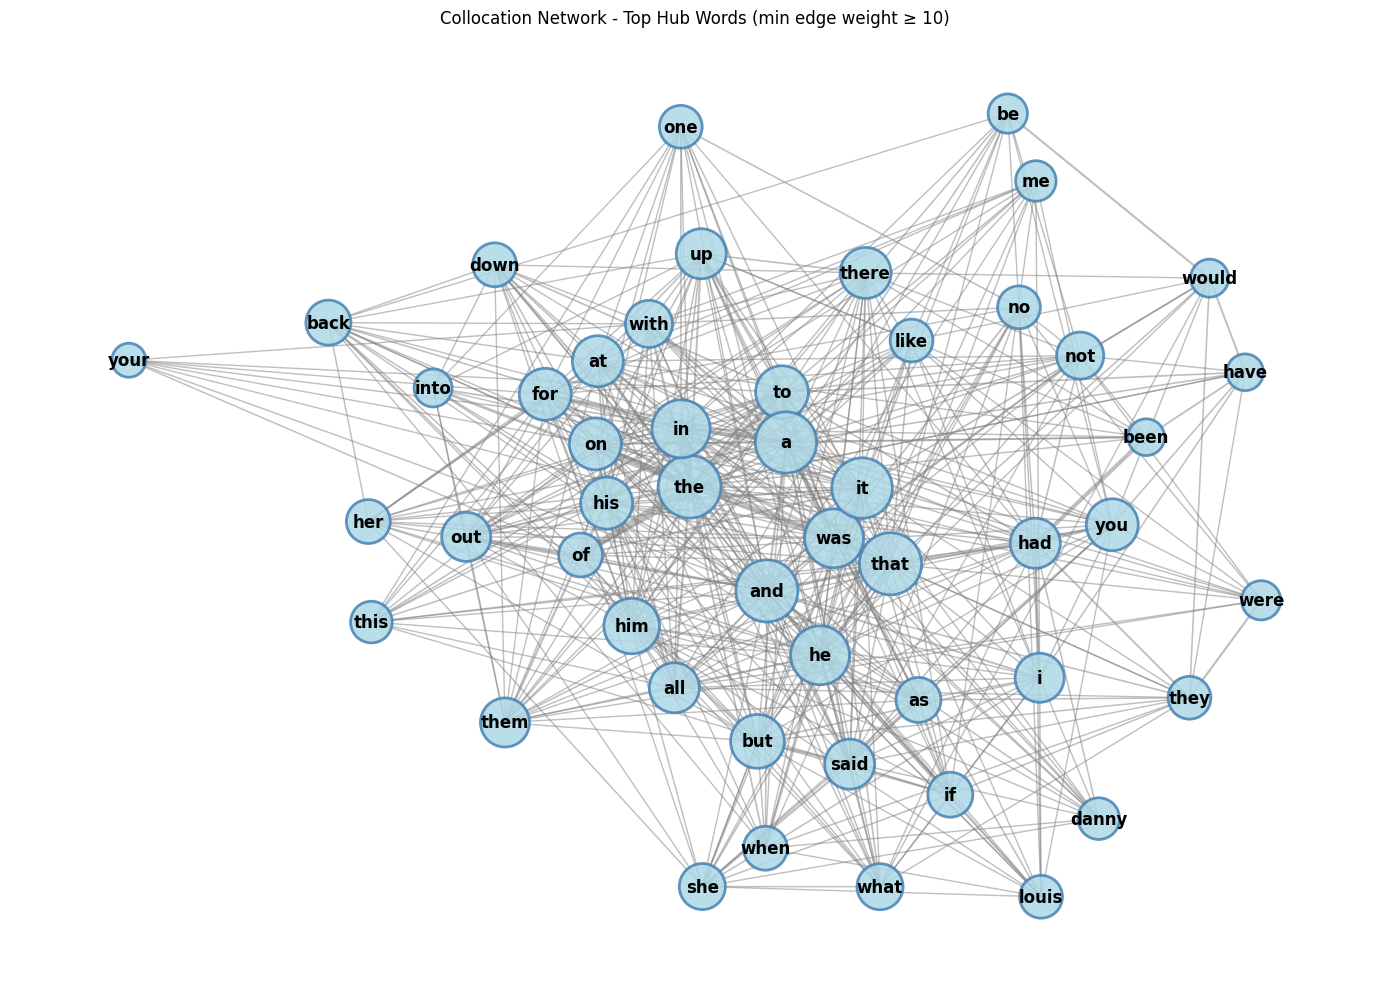

In [28]:
# Strategy: Show only strongest edges between high-degree nodes
# This creates a much cleaner, more readable network

# 1. Select top hubs by degree
top_n_hubs = 50  # start with top 20 hub words
deg = dict(H.degree())
top_hubs = set(sorted(deg, key=deg.get, reverse=True)[:top_n_hubs])

# 2. Filter to only include edges between these hubs with strong connections
# Only keep edges where BOTH nodes are hubs AND edge weight is high
edge_weights = [(u, v, d['weight']) for u, v, d in H.edges(data=True)]
edge_weights.sort(key=lambda x: x[2], reverse=True)

# Keep only edges where both nodes are in top hubs and weight is above threshold
min_edge_weight = CONFIG["min_ngram_count"] * 2  # stricter threshold for cleaner graph
filtered_edges = [
    (u, v, w) for u, v, w in edge_weights 
    if u in top_hubs and v in top_hubs and w >= min_edge_weight
]

# 3. Build clean filtered graph
H_filtered = nx.Graph()
for u, v, w in filtered_edges:
    H_filtered.add_edge(u, v, weight=w)

print(f"Filtered network: {H_filtered.number_of_nodes()} nodes, {H_filtered.number_of_edges()} edges")

# 4. Visualize - much cleaner now!
fig_filtered = plt.figure(figsize=(14,10))
pos = nx.spring_layout(H_filtered, k=0.8, iterations=100, seed=42)
deg_filtered = dict(H_filtered.degree())
wts_filtered = [H_filtered[u][v]["weight"] for u,v in H_filtered.edges()]

if wts_filtered and H_filtered.number_of_nodes() > 0:
    wmin, wmax = min(wts_filtered), max(wts_filtered)
    ew_filtered = [1 + 4*(w - wmin)/(wmax - wmin + 1e-9) for w in wts_filtered]
    
    # Draw nodes with size based on degree
    node_sizes = [200 + 50*deg_filtered[n] for n in H_filtered]
    nx.draw_networkx_nodes(H_filtered, pos, node_size=node_sizes, alpha=0.85, node_color='lightblue', edgecolors='steelblue', linewidths=2)
    nx.draw_networkx_edges(H_filtered, pos, width=ew_filtered, alpha=0.5, edge_color='gray')
    
    # Label all nodes - now readable!
    nx.draw_networkx_labels(H_filtered, pos, font_size=12, font_weight='bold')
    
    plt.title(f"Collocation Network - Top Hub Words (min edge weight ≥ {min_edge_weight})")
    plt.axis("off"); plt.tight_layout(); plt.show()
else:
    print(f"Graph too sparse. Try lowering min_edge_weight (currently {min_edge_weight}) or increase top_n_hubs.")

Can you now filter for stopwords and look again at the network?

Pet Sematary graph: 17 nodes, 87 edges
The Shining graph: 15 nodes, 38 edges


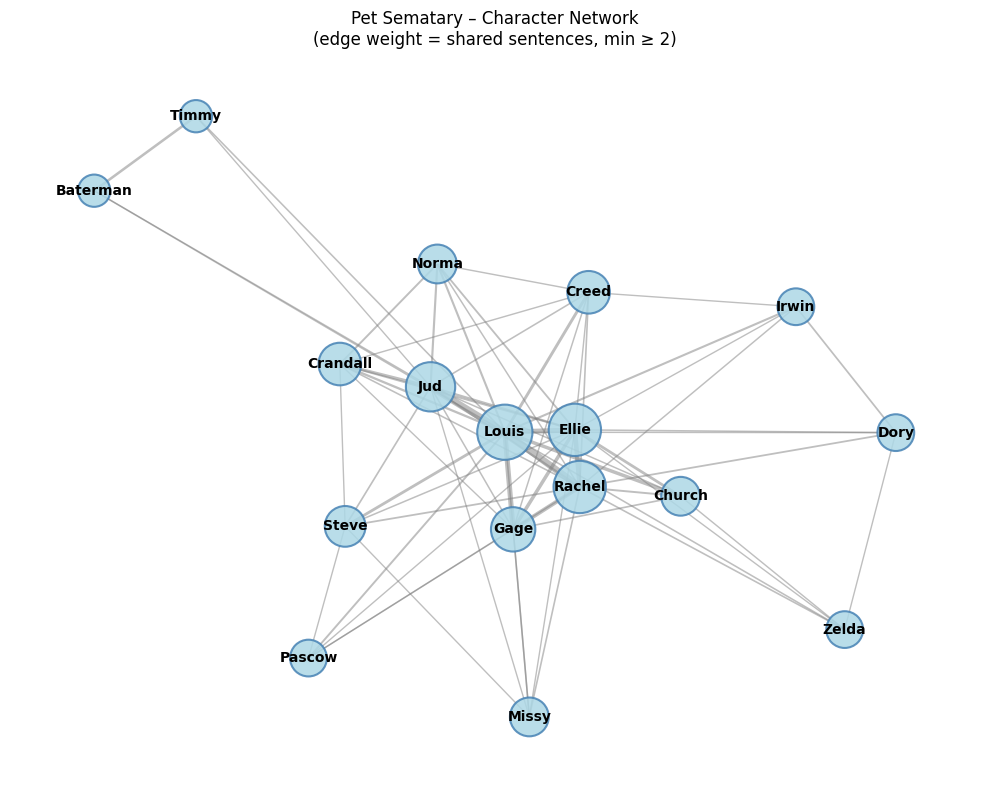

Top character co-occurrences for Pet Sematary – Character Network:
       Louis – Rachel     : 111 sentences
         Jud – Louis      : 108 sentences
       Louis – Gage       : 74 sentences
       Louis – Ellie      : 73 sentences
       Ellie – Rachel     : 64 sentences
      Rachel – Gage       : 54 sentences
       Ellie – Gage       : 44 sentences
       Louis – Church     : 43 sentences
         Jud – Crandall   : 32 sentences
       Louis – Creed      : 32 sentences
       Louis – Steve      : 30 sentences
       Ellie – Church     : 29 sentences
    Baterman – Timmy      : 25 sentences
       Louis – Crandall   : 20 sentences
         Jud – Ellie      : 18 sentences


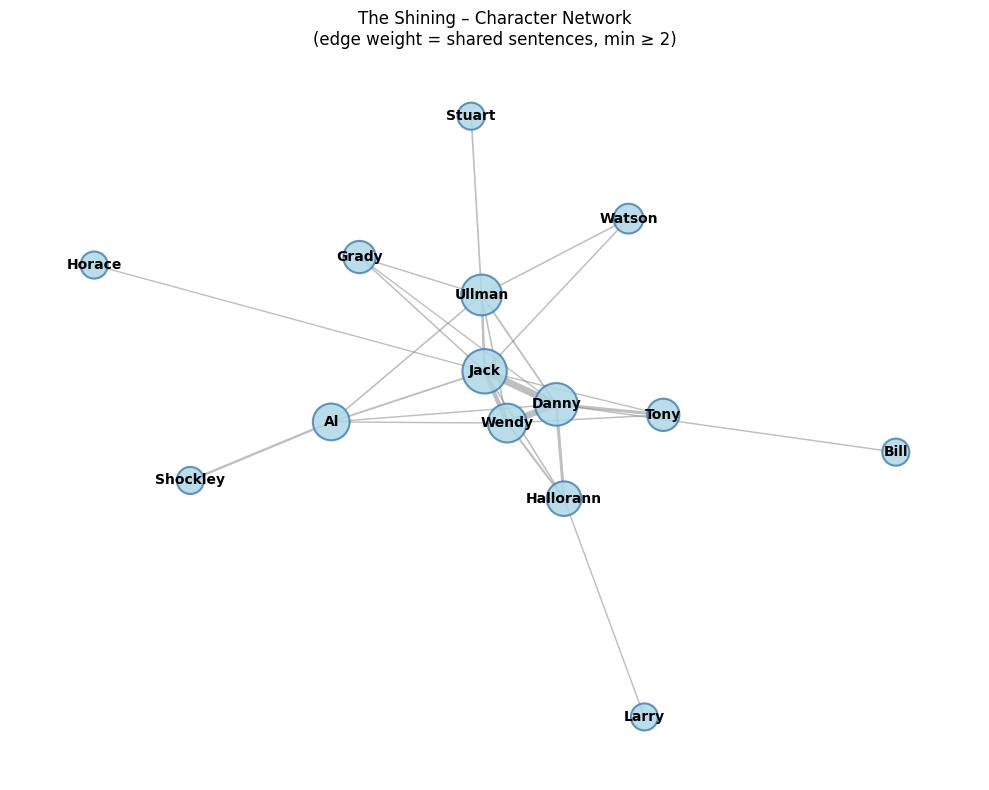

Top character co-occurrences for The Shining – Character Network:
        Jack – Danny      : 75 sentences
       Danny – Wendy      : 68 sentences
        Jack – Wendy      : 40 sentences
       Danny – Tony       : 25 sentences
       Danny – Hallorann  : 23 sentences
      Ullman – Jack       : 17 sentences
          Al – Shockley   : 15 sentences
       Wendy – Hallorann  : 12 sentences
        Jack – Al         : 9 sentences
      Ullman – Danny      : 8 sentences
      Stuart – Ullman     : 6 sentences
      Ullman – Wendy      : 5 sentences
      Ullman – Al         : 5 sentences
        Jack – Hallorann  : 5 sentences
      Ullman – Watson     : 4 sentences


In [29]:
import re
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

PET_CHARACTERS = {
    "louis", "rachel", "gage", "ellie", "jud", "crandall", "creed",
    "church", "norma", "pascow", "zelda", "missy", "timmy", "baterman",
    "irwin", "dory", "steve"
}

SH_CHARACTERS = {
    "jack", "wendy", "danny", "hallorann", "ullman", "grady", "lloyd",
    "watson", "tony", "al", "shockley", "stuart", "horace", "larry", "bill"
}

WORD_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)*")

def split_sentences(text: str):
    """Very simple sentence splitter based on ., !, ?"""
    return [s.strip() for s in re.split(r"(?<=[.!?])\s+", text) if s.strip()]

def sent_tokens(sent: str):
    """Lowercased word tokens for a single sentence."""
    return WORD_RE.findall(sent.lower())

def build_character_graph(text: str, char_lexicon: set[str]) -> nx.Graph:
    """
    Build an undirected graph:
      - nodes = characters in char_lexicon
      - edges = characters that appear in the same sentence
      - weight = number of sentences where that pair co-occurs
    """
    G = nx.Graph()
    sentences = split_sentences(text)

    for s in sentences:
        toks = sent_tokens(s)
        chars_in_sent = sorted(set(t for t in toks if t in char_lexicon))
        if len(chars_in_sent) < 2:
            continue
        for a, b in combinations(chars_in_sent, 2):
            if G.has_edge(a, b):
                G[a][b]["weight"] += 1
            else:
                G.add_edge(a, b, weight=1)
    return G

def plot_character_graph(G: nx.Graph, title: str, min_weight: int = 2):
    """
    Plot character graph, only keeping edges with weight >= min_weight.
    """
    H = nx.Graph()
    for u, v, d in G.edges(data=True):
        if d["weight"] >= min_weight:
            H.add_edge(u, v, weight=d["weight"])

    if H.number_of_nodes() == 0:
        print(f"No edges with weight ≥ {min_weight} for: {title}")
        return

    pos = nx.spring_layout(H, k=0.8, iterations=100, seed=42)
    deg = dict(H.degree())
    wts = [d["weight"] for _, _, d in H.edges(data=True)]
    wmin, wmax = min(wts), max(wts)
    edge_widths = [1 + 4 * (w - wmin) / (wmax - wmin + 1e-9) for w in wts]

    node_sizes = [300 + 80 * deg[n] for n in H.nodes()]
    labels = {n: n.title() for n in H.nodes()}  # capitalize

    fig = plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(
        H, pos,
        node_size=node_sizes,
        alpha=0.85,
        node_color="lightblue",
        edgecolors="steelblue",
        linewidths=1.5,
    )
    nx.draw_networkx_edges(
        H, pos,
        width=edge_widths,
        alpha=0.5,
        edge_color="gray",
    )
    nx.draw_networkx_labels(
        H, pos,
        labels=labels,
        font_size=10,
        font_weight="bold",
    )

    plt.title(f"{title}\n(edge weight = shared sentences, min ≥ {min_weight})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print top co-occurring pairs for interpretation
    edges_sorted = sorted(
        H.edges(data=True),
        key=lambda x: x[2]["weight"],
        reverse=True
    )
    print(f"Top character co-occurrences for {title}:")
    for u, v, d in edges_sorted[:15]:
        print(f"  {u.title():>10} – {v.title():<10} : {d['weight']} sentences")


# text1 = Pet Sematary, text2 = The Shining (already defined earlier in your notebook)
G_pet = build_character_graph(text1, PET_CHARACTERS)
G_sh  = build_character_graph(text2, SH_CHARACTERS)

print("Pet Sematary graph:",
      G_pet.number_of_nodes(), "nodes,",
      G_pet.number_of_edges(), "edges")
print("The Shining graph:",
      G_sh.number_of_nodes(), "nodes,",
      G_sh.number_of_edges(), "edges")

plot_character_graph(G_pet, "Pet Sematary – Character Network", min_weight=2)
plot_character_graph(G_sh,  "The Shining – Character Network", min_weight=2)

## 4. Notes

- Consider removing stopwords or filtering to content-words first.
- Compare per-book networks to see shifts in phrase structure.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [30]:
from pathlib import Path

Path("../results").mkdir(exist_ok=True)

def safe_save(fig, path):
    """Save a Matplotlib Figure object safely."""
    if fig is None:
        print(f"Skipped saving {path} (figure is None)")
        return
    try:
        fig.savefig(path, dpi=200, bbox_inches="tight")
        print(f"Saved: {path}")
    except Exception as e:
        print(f"Could not save {path}: {e}")

# Save full collocation network (if defined)
safe_save(globals().get("fig_network"), "../results/collocation_network_full.png")

# Save filtered collocation network (if defined)
safe_save(globals().get("fig_filtered"), "../results/collocation_network_filtered.png")

print("✓ Finished attempting to save network figures.")

Saved: ../results/collocation_network_full.png
Saved: ../results/collocation_network_filtered.png
✓ Finished attempting to save network figures.
